<H1>Light FM Hybrid Model ANN example</H1>

<p>In this notebook, we'll be building a hybrid LightFM model on the example movielens dataset. 

We'll then store the item and user vectors, and build an ANN index over these for fast querying at scale. I've used this method to produce less than 50ms response times across more than 10 million items.</p>

We'll look at two popular Approxiamte Nearest Neighbours libraries, Annoy and NMSlib, and compare their performance.

Firstly, let's import the data and build the Light FM model, as per the example in th docs:

In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances
import timeit
import __builtin__
import time

from lightfm.datasets import fetch_movielens

movielens = fetch_movielens()

In [2]:
for key, value in movielens.items():
    print(key, type(value), value.shape)

('test', <class 'scipy.sparse.coo.coo_matrix'>, (943, 1682))
('item_features', <class 'scipy.sparse.csr.csr_matrix'>, (1682, 1682))
('train', <class 'scipy.sparse.coo.coo_matrix'>, (943, 1682))
('item_labels', <type 'numpy.ndarray'>, (1682,))
('item_feature_labels', <type 'numpy.ndarray'>, (1682,))


In [3]:
train = movielens['train']
test = movielens['test']

In [51]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

model = LightFM(learning_rate=0.05, loss='warp', no_components=64, item_alpha=0.001)

model.fit_partial(train, item_features=movielens['item_features'], epochs=20 )

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.73, test 0.09.
AUC: train 0.97, test 0.91.


We can get the item vectors by simply multiplying the item features by the models item feature embeddings:

In [52]:
item_vectors = movielens['item_features'] * model.item_embeddings

Now let's make an annoy index for item to item querying:

In [93]:
from annoy import AnnoyIndex

f = item_vectors.shape[1] # Length of item vector that will be indexed
t = AnnoyIndex(f)  
for i in xrange(item_vectors.shape[0]):
    v = item_vectors[i]
    t.add_item(i, v)

t.build(10) # 10 trees
t.save('movielens_item_Annoy_idx.ann')

True

And query the index for similar movies:

In [94]:
def nearest_movies_Annoy(movie_id, index, n=10, print_output=True):
    nn = index.get_nns_by_item(movie_id, 10)
    if print_output == True:
        print('Closest to %s : \n' % movielens['item_labels'][movie_id])
    titles = [movielens['item_labels'][i] for i in nn]
    if print_output == True:
        print("\n".join(titles))

In [95]:
nearest_movies_Annoy(90, t)

Closest to Nightmare Before Christmas, The (1993) : 

Nightmare Before Christmas, The (1993)
Beauty and the Beast (1991)
Aladdin (1992)
Lion King, The (1994)
Fantasia (1940)
E.T. the Extra-Terrestrial (1982)
Batman Returns (1992)
Bram Stoker's Dracula (1992)
Snow White and the Seven Dwarfs (1937)
Star Trek: The Wrath of Khan (1982)


Not bad, and it's very quick:

In [96]:
%%timeit
nearest_movies_Annoy(90, t, print_output=False)

The slowest run took 5.63 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 18.5 µs per loop


How about NMSlib?

In [97]:
import nmslib

# initialize a new nmslib index, using a HNSW index on Cosine Similarity
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
nms_idx.addDataPointBatch(item_vectors)
nms_idx.createIndex({'post': 2}, print_progress=True)

In [98]:
def nearest_movies_nms(movie_id, index, n=10, print_output=True):
    nn = index.knnQuery(item_vectors[movie_id], k=10)
    if print_output == True:
        print('Closest to %s : \n' % movielens['item_labels'][movie_id])
    titles = [movielens['item_labels'][i] for i in nn[0]]
    if print_output == True:
        print("\n".join(titles))

In [99]:
nearest_movies_nms(90, nms_idx, n=10)

Closest to Nightmare Before Christmas, The (1993) : 

Nightmare Before Christmas, The (1993)
Beauty and the Beast (1991)
Aladdin (1992)
Lion King, The (1994)
Fantasia (1940)
E.T. the Extra-Terrestrial (1982)
Batman Returns (1992)
Pink Floyd - The Wall (1982)
Benny & Joon (1993)
Bram Stoker's Dracula (1992)


In [100]:
%%timeit 
nearest_movies_nms(90, nms_idx, n=10, print_output=False)

The slowest run took 10.82 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 19.3 µs per loop


<p>Again, good and maybe a little better, and also very fast. Now we'll do an Annoy example showing how we can do user recommendations using a neat trick outlined by the Xbox recomendations team: https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/XboxInnerProduct.pdf . Thanks to Ben Fredrickson https://github.com/benfred/ for bringing this one to light.</p>

<p>Basically we add a nomalizing factor to each item vector - making their distances equal with each other. Then when we query with a user vector, we add a 0 to the end, and the result is proportional to the inner producct of the user and item vectors. This is a sneaky way to do an aproximate maximum inner product search.

In [101]:
norms = np.linalg.norm(item_vectors, axis=1)
max_norm = norms.max()
extra_dimension = np.sqrt(max_norm ** 2 - norms ** 2)
norm_data = np.append(item_vectors, extra_dimension.reshape(norms.shape[0], 1), axis=1)

f_member = norm_data.shape[1]
t_member = AnnoyIndex(f_member)  # Length of item vector that will be indexed

for i in xrange(norm_data.shape[0]):
    v = norm_data[i]
    t_member.add_item(i, v)
    
t_member.build(10)

True

In [102]:
# Define our user vectors

user_vectors = model.user_embeddings

<h4>Now we can query as per the standard LightFM example.</h4>

In [118]:
def sample_recommendation(user_ids, model, data, n_items=10, print_output=True):
    n_users, n_items = data['train'].shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        top_items = [data['item_labels'][i] for i in t_member.get_nns_by_vector(np.append(user_vectors[user_id], 0), 50)]
        if print_output == True:
            print("User %s" % user_id)
            print("     Known positives:")

            for x in known_positives[:3]:
                print("        %s" % x)

            print("     Recommended:")

            for x in top_items[:3]:
                print("        %s" % x)

In [119]:
sample_recommendation([3,25,450], model, movielens, print_output=True)

User 3
     Known positives:
        Seven (Se7en) (1995)
        Indiana Jones and the Last Crusade (1989)
        Contact (1997)
     Recommended:
        Air Force One (1997)
        Kiss the Girls (1997)
        Game, The (1997)
User 25
     Known positives:
        Toy Story (1995)
        Twelve Monkeys (1995)
        Dead Man Walking (1995)
     Recommended:
        Independence Day (ID4) (1996)
        Mission: Impossible (1996)
        Men in Black (1997)
User 450
     Known positives:
        Kolya (1996)
        Devil's Own, The (1997)
        Contact (1997)
     Recommended:
        Hoodlum (1997)
        Edge, The (1997)
        Career Girls (1997)


<h4>Compare this to the original, non-ANN version here:</h4>

In [116]:
def sample_recommendation_original(model, data, user_ids, print_output=True):

    n_users, n_items = data['train'].shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]
        if print_output == True:
            print("User %s" % user_id)
            print("     Known positives:")

            for x in known_positives[:3]:
                print("        %s" % x)

            print("     Recommended:")

            for x in top_items[:3]:
                print("        %s" % x)

In [117]:
sample_recommendation_original(model, movielens, [3, 25, 450])

User 3
     Known positives:
        Seven (Se7en) (1995)
        Indiana Jones and the Last Crusade (1989)
        Contact (1997)
     Recommended:
        Air Force One (1997)
        Scream (1996)
        Contact (1997)
User 25
     Known positives:
        Toy Story (1995)
        Twelve Monkeys (1995)
        Dead Man Walking (1995)
     Recommended:
        Independence Day (ID4) (1996)
        Mission: Impossible (1996)
        Fargo (1996)
User 450
     Known positives:
        Kolya (1996)
        Devil's Own, The (1997)
        Contact (1997)
     Recommended:
        Hoodlum (1997)
        G.I. Jane (1997)
        Edge, The (1997)


So pretty similar! How about speed?

In [110]:
%%timeit
sample_recommendation_original(model, movielens, [3, 25, 450], print_output=False)

100 loops, best of 3: 4.19 ms per loop


In [213]:
%%timeit
sample_recommendation([3,25,450], model, movielens, print_output=False)

100 loops, best of 3: 2.72 ms per loop


So a small difference at thes volumes, but let's see how it compares to an sklearn distance method as n increases:

In [243]:
def time_recommend_item_for_item():
    t = timeit.Timer("recommend_item_for_item(item_vectors[0].reshape(1, -1), data, 10)")
    time = t.timeit(100)
    return time

def time_Annoy_recommend_item_for_item():
    t = timeit.Timer("temp_t.get_nns_by_vector(item_vectors[0], 10)")
    time = t.timeit(100)
    return time

def time_nms_recommend_item_for_item():
    t = timeit.Timer("nms_idx.knnQuery(item_vectors[0])[0]")
    time = t.timeit(100)
    return time

Annoy_response_times = []
pairwise_response_times = []
nms_response_times = []

f = item_vectors.shape[1]

for i in range (1, 500, 50):
    data = np.repeat(item_vectors, i, axis=0)
    __builtin__.__dict__.update(locals())
    
    pairwise_response_times.append(time_recommend_item_for_item())
    
    #NMS lib
    
    nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
    nms_idx.addDataPointBatch(data)
    nms_idx.createIndex({'post': 2}, print_progress=False)
    __builtin__.__dict__.update(locals())
    nms_response_times.append(time_nms_recommend_item_for_item())  
    
    #Annoy
    
    temp_idx = AnnoyIndex(f)
    temp_t = AnnoyIndex(f)  
    for i in xrange(data.shape[0]):
        v = data[i]
        temp_t.add_item(i, v)
    temp_t.build(10) # 10 trees
    __builtin__.__dict__.update(locals())
    Annoy_response_times.append(time_Annoy_recommend_item_for_item())    

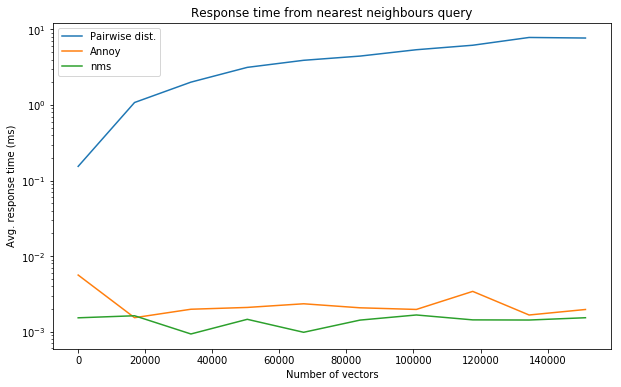

In [244]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(10)
x = (x*10) * 1681
plt.figure(figsize=(10,6))
plt.plot(x, pairwise_response_times)
plt.plot(x, Annoy_response_times[:10])
plt.plot(x, nms_response_times)
plt.title('Response time from nearest neighbours query')
plt.legend(['Pairwise dist.', 'Annoy', 'nms'], loc='upper left')
plt.xlabel('Number of vectors')
plt.ylabel('Avg. response time (ms)')
plt.yscale('log')
plt.show()

<h3>So, should you use one of these libraries?</h3>

On a smaller dataset, it's not worth the hassle and loss of accuracy for a small increase in speed. However, if you need to respond in < 100ms, then your vector set can only grow so large before you'll need to start thinking about one of these libraries. 

Annoy has the advantage of saving to a memory map, and so playing well with multiple processes in a production environment

NMSlib has generally been shown to outperform Annoy in terms of speed and accuracy, but I also found that constructing indexes over a large dataset was quite slow. This becomes a problem if you have to rebuild your index frequently because of fast moving product catalogues etc. 